In [8]:
import pandas as pd
import yfinance as yf
import datetime
import json
import numpy as np
import os
import torch

In [3]:
stock_data = os.listdir('../data/dataset/stock_data')
stock_data

['raw_AAL.csv',
 'raw_AMC.csv',
 'raw_BB.csv',
 'raw_BBBY.csv',
 'raw_GME.csv',
 'raw_PLTR.csv']

In [10]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
with open('../data/models/wordlist/word_list_extended.txt','r') as f:
    lmdict = eval(f.read())

special_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -10,
    'exploded' : 4,
    'able':2,
}

for i in lmdict["Negative"]:
  special_words[i]=-5

for i in lmdict["Positive"]:
  special_words[i]=5

vader = SentimentIntensityAnalyzer()
vader.lexicon.update(special_words)

In [4]:
from pathlib import Path
from transformers import AutoModelForSequenceClassification, BertTokenizer
import os
import torch.nn.functional as F
import math

In [5]:
lm_path = 'ProsusAI/finbert'
MAX_LEN = 512
bertmodel = AutoModelForSequenceClassification.from_pretrained(lm_path,cache_dir=None, num_labels=3)
tokenizer = BertTokenizer.from_pretrained(lm_path)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def FinBert_predict(text):
    encoded_text = tokenizer.encode_plus(
  text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding=False,
  return_attention_mask=True,
  return_tensors='pt',
)
    input_ids = encoded_text['input_ids'].to(device)
    attention_mask = encoded_text['attention_mask'].to(device)
    logits = bertmodel(input_ids, attention_mask).logits
    probabilities = F.softmax(logits, dim=-1)
    return probabilities.detach().numpy()


In [9]:
raw_df = pd.read_csv(f'../data/dataset/stock_data/raw_PLTR.csv')

In [10]:
raw_df['topic']

0                 3 Meme Stocks That Could Make You Rich
1      Activists Launch Campaign Against Palantir's N...
2      Palantir Backs Multiple SPACs Endeavors in Dig...
3      UK healthcare app built by Iranian refugee set...
4      Continue to Exercise Caution When it Comes to ...
                             ...                        
167    Cramer Gives His Opinion On United Microelectr...
168               Palantir And AWS Team Up For ERP Suite
169    Meet Alteryx, A Big Data Analytics Competitor ...
170    Jim Cramer on Jobs Report, Broadcom, Costco, P...
171    Palantir Rises on Latest Ark Investment Stock ...
Name: topic, Length: 172, dtype: object

In [77]:
df_logits = pd.DataFrame(contents_logits, columns=['neg', 'neu', 'pos'])

In [64]:
list_sentiment = [(N/(N+Ne+P), (P-N)/(P+N), math.log((1+P)/(1+N))) for N,Ne,P in df_logits.values]
df_sentiment = pd.DataFrame(list_sentiment, columns=['neg1','pos1','pos2'])

In [26]:
#NEW

df_list = []
for name in stock_data:
    raw_df = pd.read_csv(f'../data/dataset/stock_data/{name}')
    print(name,"--------------------------------------")
    print(raw_df.info())
    raw_df['Date'] = raw_df['Date'].apply(lambda x :datetime.datetime.strptime(x[:-8],r"%Y-%m-%dT%H:%M"))
    raw_df.set_index('Date',inplace=True)
    raw_df.index = raw_df.index.ceil('H')
    a = raw_df.index.value_counts()
    print(a[a.values>1])

    for col in raw_df.columns:
        raw_df[col] = raw_df[col] + ' '
    raw_df = raw_df.groupby(level=0).sum()

    #applying NLP model!!!!
    for para in ['topic','content']:
        print(para,"--------")
        contents_logits = [ FinBert_predict(content_text).tolist()[0] for content_text in raw_df[para] ]
        df_logits = pd.DataFrame(contents_logits, columns=[f'neg', f'neu', f'pos'])
        list_sentiment = [(N/(N+Ne+P), (P-N)/(P+N), math.log((1+P)/(1+N))) for N,Ne,P in df_logits.values]
        df_sentiment = pd.DataFrame(list_sentiment, columns=[f'neg1_{para}',f'pos1_{para}',f'pos2_{para}'], index=raw_df.index)
        raw_df = pd.concat([raw_df,df_sentiment], axis=1)
    #that mean is shitty, handling multiple news on the same hours
    try:
        raw_df = raw_df.drop(['topic','content','url'], axis=1)
    except:
        raw_df = raw_df.drop(['topic','content'], axis=1)
    raw_df = raw_df.groupby(level=0).mean()

    df_price = yf.download(tickers='PLTR', period='6mo', interval="1h")
    df_price.index = df_price.index.tz_convert(None)

    df = pd.concat([raw_df, df_price], axis=1)
    df.fillna(0,inplace=True)
    
    #should subject to each range of data
    df_slim = df[df.index>datetime.datetime(2021,3,4,10)]
    print(list(map(lambda x : df[x].mask(df[x] != 0, 1).value_counts(), ['pos1_topic','pos1_content'])))
    df_list.append(raw_df)

raw_AAL.csv --------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Date     175 non-null    object
 1   topic    175 non-null    object
 2   content  175 non-null    object
 3   url      175 non-null    object
dtypes: object(4)
memory usage: 5.6+ KB
None
2021-04-22 15:00:00    5
2021-04-22 12:00:00    4
2021-05-10 16:00:00    2
2021-05-09 17:00:00    2
2021-03-30 17:00:00    2
2021-05-12 21:00:00    2
2021-04-22 09:00:00    2
2021-03-30 21:00:00    2
2021-04-22 14:00:00    2
2021-06-07 22:00:00    2
2021-04-13 13:00:00    2
2021-06-03 16:00:00    2
2021-03-29 21:00:00    2
2021-04-01 22:00:00    2
2021-05-11 02:00:00    2
2021-04-28 17:00:00    2
2021-04-22 13:00:00    2
2021-05-07 16:00:00    2
2021-04-14 13:00:00    2
Name: Date, dtype: int64
topic --------
content --------
[*********************100%********************

KeyError: "['url'] not found in axis"

In [43]:
!dir ../data/dataset/prep_data/processed

 Volume in drive G is G
 Volume Serial Number is 1C7D-A999

 Directory of g:\xasm\ftds_capstone\FTDS_capstone\data\dataset\prep_data\processed

06/17/2021  05:01 AM    <DIR>          .
06/17/2021  05:01 AM    <DIR>          ..
               0 File(s)              0 bytes
               2 Dir(s)  17,818,697,728 bytes free


In [45]:
for name in stock_data:
    ind = stock_data.index(name)
    df_list[0].to_csv(f'../data/dataset/prep_data/processed/SA_{name[:-4]}_v1.csv')

In [104]:
raw_df.groupby(level = 0).sum().index.is_unique

True

<AxesSubplot:>

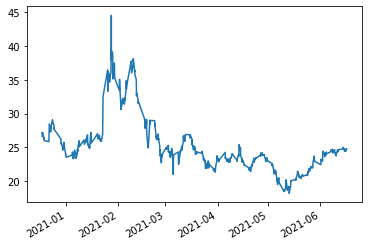

In [88]:
df_price['Adj Close'].plot.line()

<AxesSubplot:xlabel='Date'>

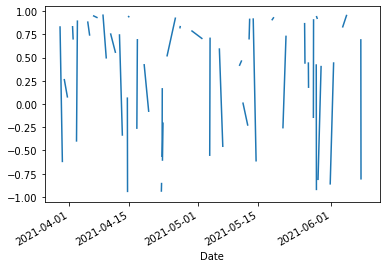

In [90]:
raw_df['pos1'].plot.bar()

In [12]:
#OLD
df_list = set()
for name in stock_data:
    raw_df = pd.read_csv(f'../data/dataset/stock_data/{name}')
    print(name,"--------------------------------------")
    print(raw_df.info())
    raw_df['Date'] = raw_df['Date'].apply(lambda x :datetime.datetime.strptime(x[:-8],r"%Y-%m-%dT%H:%M"))
    raw_df.set_index('Date',inplace=True)
    raw_df.index = raw_df.index.ceil('H')
    a = raw_df.index.value_counts()
    print(a[a.values>1])

    for col in raw_df.columns:
        raw_df[col] = raw_df[col] + ' '
    raw_df = raw_df.groupby(level=0).sum()

    #applying NLP model!!!!
    raw_df['topic_comp'] = raw_df['topic'].apply(lambda x: vader.polarity_scores(x)['compound'])
    raw_df['content_comp'] = raw_df['content'].apply(lambda x: vader.polarity_scores(x)['compound'])
    raw_df['topic_logpos'] = raw_df['topic'].apply(log_pos)
    raw_df['content_logpos'] = raw_df['content'].apply(log_pos)

    df_price = yf.download(tickers='PLTR', period='6mo', interval="1h")
    df_price.index = df_price.index.tz_convert(None)

    df = pd.concat([raw_df.drop(['topic','content'],axis=1),df_price], axis=1)
    df.fillna(0,inplace=True)
    
    #should subject to each range of data
    df_slim = df[df.index>datetime.datetime(2021,3,4,10)]
    print(list(map(lambda x : df[x].mask(df[x] != 0, 1).value_counts(), ['topic_comp','content_comp'])))
    df_list.append(raw_df)

raw_AAL.csv --------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Date     175 non-null    object
 1   topic    175 non-null    object
 2   content  175 non-null    object
 3   url      175 non-null    object
dtypes: object(4)
memory usage: 5.6+ KB
None
2021-04-22 15:00:00    5
2021-04-22 12:00:00    4
2021-05-10 16:00:00    2
2021-05-09 17:00:00    2
2021-03-30 17:00:00    2
2021-05-12 21:00:00    2
2021-04-22 09:00:00    2
2021-03-30 21:00:00    2
2021-04-22 14:00:00    2
2021-06-07 22:00:00    2
2021-04-13 13:00:00    2
2021-06-03 16:00:00    2
2021-03-29 21:00:00    2
2021-04-01 22:00:00    2
2021-05-11 02:00:00    2
2021-04-28 17:00:00    2
2021-04-22 13:00:00    2
2021-05-07 16:00:00    2
2021-04-14 13:00:00    2
Name: Date, dtype: int64
[*********************100%***********************]  1 of 1 completed
[0.0    9